## BERT input tokenization

In [48]:
from transformers import AutoTokenizer

def tokenize_text(text, model_name='bert-base-uncased'):
    # Load pre-trained tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    
    # Extract token IDs and convert to tokens
    token_ids = inputs['input_ids'][0]
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    
    return tokens, token_ids

# Example
text = "The king rules the kingdom"
tokens, token_ids = tokenize_text(text)

print("Original text:", text)
print("Tokens:      ", tokens)
print("Token IDs:   ", token_ids.tolist())

Original text: The king rules the kingdom
Tokens:       ['[CLS]', 'the', 'king', 'rules', 'the', 'kingdom', '[SEP]']
Token IDs:    [101, 1996, 2332, 3513, 1996, 2983, 102]


## Calcuate Word Embeddings

In [49]:
import torch
from transformers import AutoTokenizer, AutoModel

def get_token_embeddings(text, model_name='bert-base-uncased'):
    # Load pre-trained tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # Get model outputs (embeddings)
    with torch.no_grad():
        # unpack a dictionary and pass its key-value pairs 
        # as keyword arguments to a function 
        outputs = model(**inputs)
    
    # Extract embeddings from the last hidden state
    embeddings = outputs.last_hidden_state[0]  
    print(embeddings.shape)
    # Shape: (sequence_length, 768)
    
    return tokens, embeddings

# Example: Getting embeddings for tokens
text = "The king rules the kingdom"
tokens, embeddings = get_token_embeddings(text)
print("Tokens and their embeddings (first 5 dimensions):")
for token, emb in zip(tokens, embeddings):
    print(f"{token}: {emb[:5].numpy()}...")

torch.Size([7, 768])
Tokens and their embeddings (first 5 dimensions):
[CLS]: [-0.29844123  0.6102891   0.15138927 -0.06507589 -0.44881746]...
the: [-0.54813766  0.0798662  -0.1852346   0.21140489 -0.09343444]...
king: [ 0.09419857  0.09978478  0.60134786 -0.02520893 -0.02910186]...
rules: [ 0.03675649  0.2432631  -0.2417559  -0.2521967  -0.08357717]...
the: [-0.4276377  -0.2732732   0.3628907  -0.5024754   0.15975913]...
kingdom: [ 0.00768744 -0.48735484  0.2892718   0.12761931  0.2640031 ]...
[SEP]: [ 0.80087405  0.08718775 -0.2546647   0.5996189  -0.65110075]...


## Magnitude-normalized word embeddings

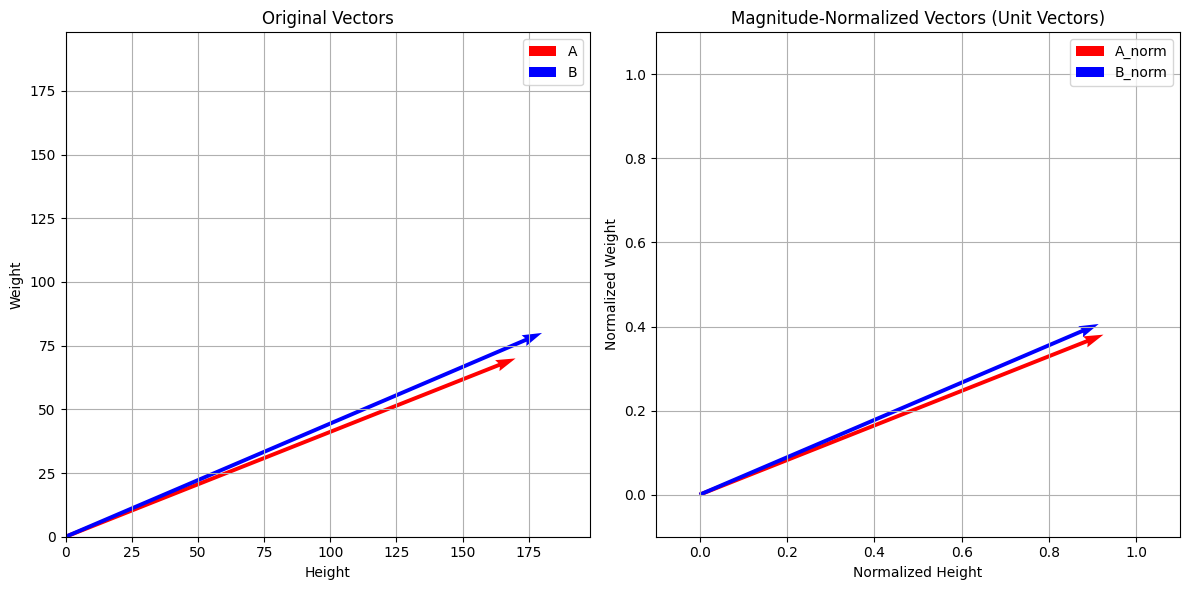

Cosine Similarity (Original): Approximately 0.999866
Cosine Similarity (Magnitude-Normalized Vectors): Approximately 0.9994


In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Original data
A_original = np.array([170, 70])
B_original = np.array([180, 80])

# Magnitude-normalized data
A_norm_mag = np.array([170/np.linalg.norm(A_original), 70/np.linalg.norm(A_original)])
B_norm_mag = np.array([180/np.linalg.norm(B_original), 80/np.linalg.norm(B_original)])

# Plotting function
def plot_vectors_magnitude_norm(v1_orig, v2_orig, v1_norm, v2_norm):
    plt.figure(figsize=(12, 6))

    # Plot Original Vectors
    plt.subplot(1, 2, 1)
    plt.quiver(0, 0, v1_orig[0], v1_orig[1], angles='xy', scale_units='xy', scale=1, color='r', label='A')
    plt.quiver(0, 0, v2_orig[0], v2_orig[1], angles='xy', scale_units='xy', scale=1, color='b', label='B')
    plt.xlabel('Height')
    plt.ylabel('Weight')
    plt.title('Original Vectors')
    plt.xlim(0, max(max(v1_orig), max(v2_orig)) * 1.1)
    plt.ylim(0, max(max(v1_orig), max(v2_orig)) * 1.1)
    plt.legend()
    plt.grid(True)

    # Plot Magnitude-Normalized Vectors
    plt.subplot(1, 2, 2)
    plt.quiver(0, 0, v1_norm[0], v1_norm[1], angles='xy', scale_units='xy', scale=1, color='r', label='A_norm')
    plt.quiver(0, 0, v2_norm[0], v2_norm[1], angles='xy', scale_units='xy', scale=1, color='b', label='B_norm')
    plt.xlabel('Normalized Height')
    plt.ylabel('Normalized Weight')
    plt.title('Magnitude-Normalized Vectors (Unit Vectors)')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plotting
plot_vectors_magnitude_norm(A_original, B_original, A_norm_mag, B_norm_mag)

print(f"Cosine Similarity (Original): Approximately {0.999866}")
print(f"Cosine Similarity (Magnitude-Normalized Vectors): Approximately {0.9994}")

## Cosine Similarity between words:

In [50]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

def get_word_embeddings(text, model_name='bert-base-uncased'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[0]
    
    word_emb_dict = {}
    for token, emb in zip(tokens, embeddings):
        if token not in ['[CLS]', '[SEP]']:
            word_emb_dict[token] = emb
    return word_emb_dict

def compute_similarity(word_emb_dict):
    words = list(word_emb_dict.keys())
    embeddings = torch.stack([word_emb_dict[word] for word in words]).numpy()
    similarities = cosine_similarity(embeddings)
    
    relation_matrix = {}
    for i, word1 in enumerate(words):
        relation_matrix[word1] = {}
        for j, word2 in enumerate(words):
            relation_matrix[word1][word2] = similarities[i][j]
    return relation_matrix

# Example: Measuring similarity between words
if __name__ == "__main__":
    text = "The king rules the kingdom and the queen governs"
    word_emb_dict = get_word_embeddings(text)
    relation_matrix = compute_similarity(word_emb_dict)
    print("Cosine Similarity between words:")
    for word1 in relation_matrix:
        print(f"\n{word1}:")
        for word2, similarity in relation_matrix[word1].items():
            print(f"  {word2}: {similarity:.4f}")

Cosine Similarity between words:

the:
  the: 1.0000
  king: 0.5347
  rules: 0.6333
  kingdom: 0.4193
  and: 0.6179
  queen: 0.5356
  govern: 0.5052
  ##s: 0.6915

king:
  the: 0.5347
  king: 1.0000
  rules: 0.5543
  kingdom: 0.7628
  and: 0.4104
  queen: 0.6944
  govern: 0.4572
  ##s: 0.4637

rules:
  the: 0.6333
  king: 0.5543
  rules: 1.0000
  kingdom: 0.5100
  and: 0.5204
  queen: 0.5216
  govern: 0.8282
  ##s: 0.7327

kingdom:
  the: 0.4193
  king: 0.7628
  rules: 0.5100
  kingdom: 1.0000
  and: 0.3829
  queen: 0.5706
  govern: 0.4558
  ##s: 0.4068

and:
  the: 0.6179
  king: 0.4104
  rules: 0.5204
  kingdom: 0.3829
  and: 1.0000
  queen: 0.3631
  govern: 0.4269
  ##s: 0.5884

queen:
  the: 0.5356
  king: 0.6944
  rules: 0.5216
  kingdom: 0.5706
  and: 0.3631
  queen: 1.0000
  govern: 0.4541
  ##s: 0.4744

govern:
  the: 0.5052
  king: 0.4572
  rules: 0.8282
  kingdom: 0.4558
  and: 0.4269
  queen: 0.4541
  govern: 1.0000
  ##s: 0.5646

##s:
  the: 0.6915
  king: 0.4637
  rules: 0

## Visualizing Cosine Similarity between words

Heatmap saved as 'similarity_heatmap.png'


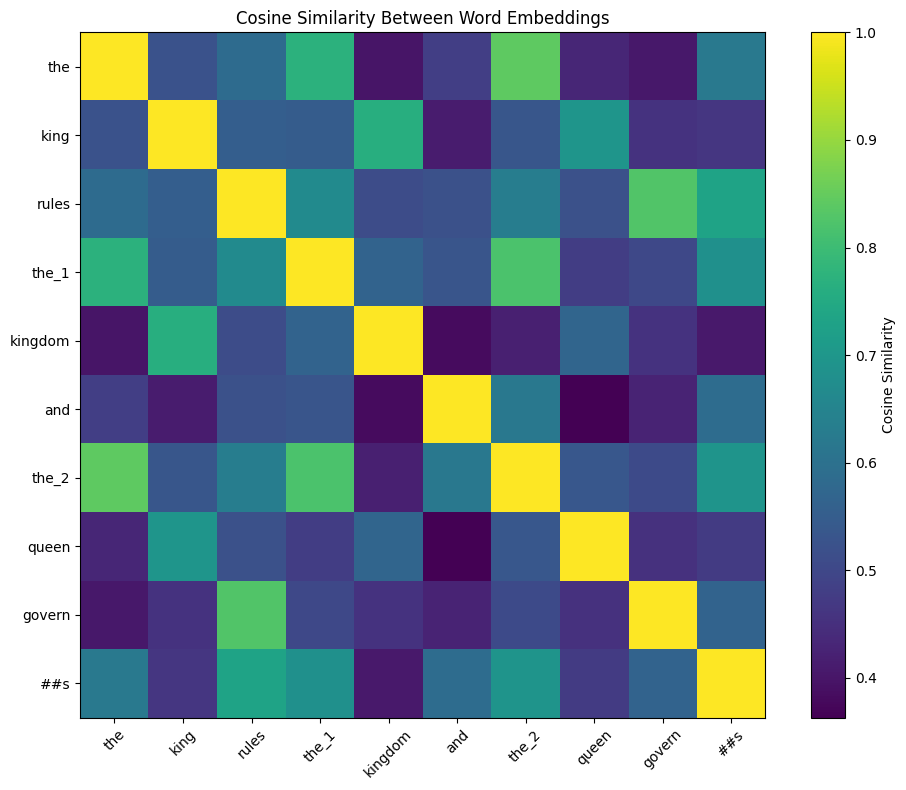

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

def get_word_embeddings(text, model_name='bert-base-uncased'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[0]
    
    word_emb_dict = {}
    for token, emb in zip(tokens, embeddings):
        if token not in ['[CLS]', '[SEP]']:
            if token == 'the' and token in word_emb_dict:
                word_emb_dict[f'the_{len([k for k in word_emb_dict.keys() if k.startswith("the_")])+1}'] = emb
            elif token not in word_emb_dict:
                word_emb_dict[token] = emb
    return word_emb_dict

def compute_similarity(word_emb_dict):
    words = list(word_emb_dict.keys())
    embeddings = torch.stack([word_emb_dict[word] for word in words]).numpy()
    similarities = cosine_similarity(embeddings)
    return words, similarities

def visualize_similarity(words, similarities):
    plt.figure(figsize=(10, 8))
    plt.imshow(similarities, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Cosine Similarity')
    plt.xticks(np.arange(len(words)), words, rotation=45)
    plt.yticks(np.arange(len(words)), words)
    plt.title('Cosine Similarity Between Word Embeddings')
    plt.tight_layout()
    
    # Save the plot
    # plt.savefig('similarity_heatmap.png')

# Example: Visualizing similarity
if __name__ == "__main__":
    text = "The king rules the kingdom and the queen governs"
    word_emb_dict = get_word_embeddings(text)
    words, similarities = compute_similarity(word_emb_dict)
    visualize_similarity(words, similarities)
    print("Heatmap saved as 'similarity_heatmap.png'")

## Word Analogy: king - man + woman ≈ queen
- Similarity between (king - man + woman) and queen

In [52]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

def get_word_embeddings(texts, target_words, model_name='bert-base-uncased'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    word_emb_dict = {}
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[0]
        
        for token, emb in zip(tokens, embeddings):
            if token in target_words and token not in word_emb_dict:
                word_emb_dict[token] = emb
    
    return word_emb_dict

# Example: Demonstrating word analogy
if __name__ == "__main__":
    texts = [
        "The king rules the kingdom",
        "The queen governs the realm",
        "The man works in the city",
        "The woman lives in the town"
    ]
    target_words = ['king', 'queen', 'man', 'woman']
    
    # Get embeddings for target words
    word_emb_dict = get_word_embeddings(texts, target_words)
    
    # Perform analogy: king - man + woman ≈ queen
    king_emb = word_emb_dict['king']
    man_emb = word_emb_dict['man']
    woman_emb = word_emb_dict['woman']
    queen_emb = word_emb_dict['queen']
    
    analogy_vector = king_emb - man_emb + woman_emb
    analogy_similarity = cosine_similarity(analogy_vector.unsqueeze(0).numpy(), 
                                        queen_emb.unsqueeze(0).numpy())[0][0]
    
    print("Word Analogy: king - man + woman ≈ queen")
    print(f"Similarity between (king - man + woman) and queen: {analogy_similarity:.4f}")

Word Analogy: king - man + woman ≈ queen
Similarity between (king - man + woman) and queen: 0.7002


## 3D Word Analogy Visualization: king - man + woman ≈ queen

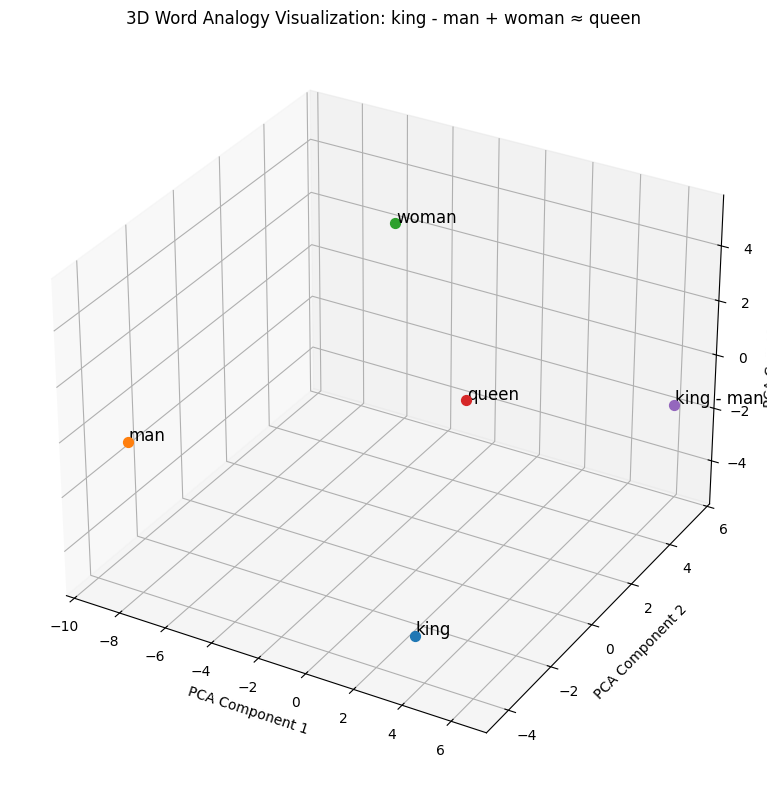

In [60]:
# Re-run everything after kernel reset
# Re-import required packages after code execution state reset
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D # Import for 3D plotting
from transformers import AutoTokenizer, AutoModel

# Define text and target words
texts = [
    "The king rules the kingdom",
    "The queen governs the realm",
    "The man works in the city",
    "The woman lives in the town"
]
target_words = ['king', 'queen', 'man', 'woman']

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

# Extract embeddings for target words
word_emb_dict = {}
for text in texts:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[0]

    for token, emb in zip(tokens, embeddings):
        # We only want the first occurrence of each target word to ensure consistent embedding
        if token in target_words and token not in word_emb_dict:
            word_emb_dict[token] = emb

# Ensure all target words were found
if len(word_emb_dict) < len(target_words):
    print(f"Warning: Not all target words were found. Found: {list(word_emb_dict.keys())}")
    # Handle missing words, e.g., by skipping the analogy or using a placeholder
    # For this example, we'll stop if a key word for the analogy is missing.
    if 'king' not in word_emb_dict or 'man' not in word_emb_dict or \
       'woman' not in word_emb_dict or 'queen' not in word_emb_dict:
        print("Essential words for the analogy are missing. Exiting.")
        exit()


# Prepare vectors for analogy
king_emb = word_emb_dict['king']
man_emb = word_emb_dict['man']
woman_emb = word_emb_dict['woman']
queen_emb = word_emb_dict['queen']

# Compute analogy vector
analogy_vector = king_emb - man_emb + woman_emb

# Reduce dimensions using PCA
vectors = torch.stack([king_emb, man_emb, woman_emb, queen_emb, analogy_vector])
labels = ['king', 'man', 'woman', 'queen', 'king - man + woman']

# Change n_components to 3 for 3D visualization
pca = PCA(n_components=3)
reduced = pca.fit_transform(vectors.detach().numpy()) # Use .detach().numpy() for tensors

# Plot
fig = plt.figure(figsize=(10, 8)) # Adjusted figure size for 3D
ax = fig.add_subplot(111, projection='3d') # Create a 3D subplot

for i, label in enumerate(labels):
    x, y, z = reduced[i]
    ax.scatter(x, y, z, s=50) # s is the marker size
    ax.text(x + 0.01, y + 0.01, z + 0.01, label, fontsize=12)

ax.set_title("3D Word Analogy Visualization: king - man + woman ≈ queen")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
plt.grid(True)
plt.tight_layout()
plt.show()

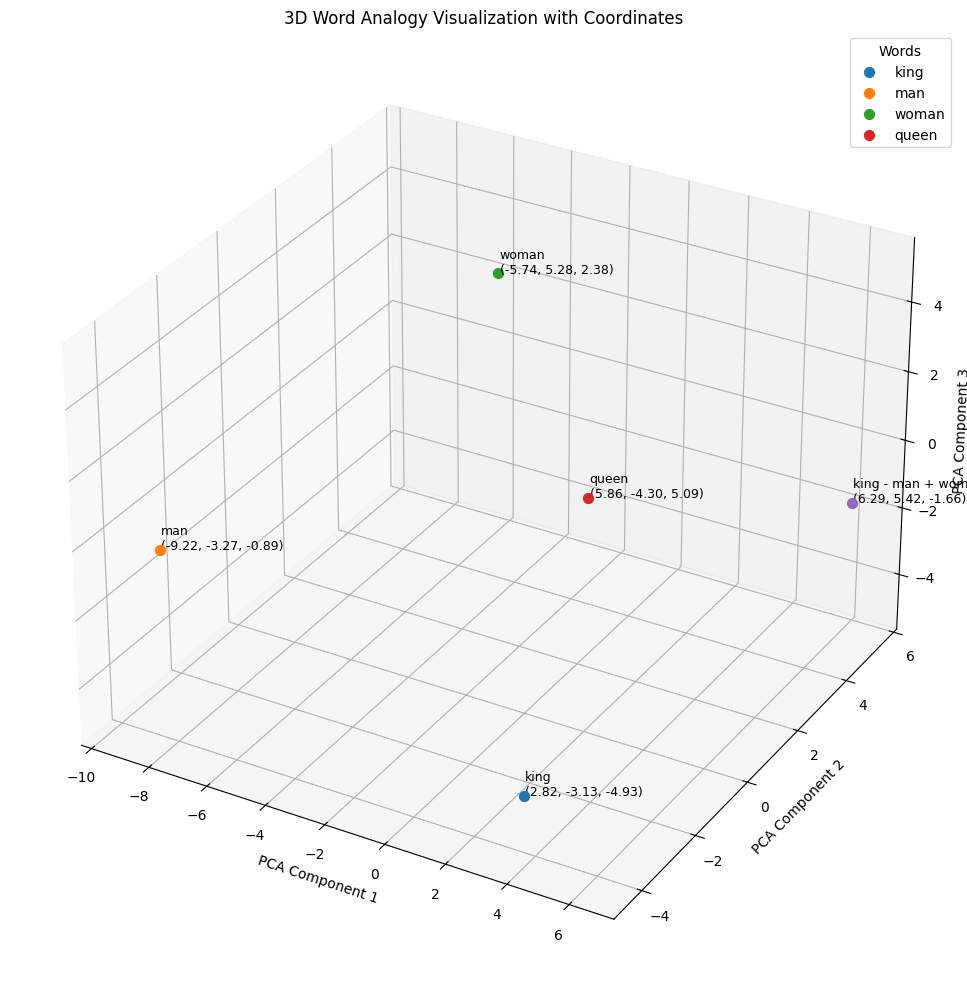

In [61]:
# Re-run everything after kernel reset
# Re-import required packages after code execution state reset
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D # Import for 3D plotting
from transformers import AutoTokenizer, AutoModel

# Define text and target words
texts = [
    "The king rules the kingdom",
    "The queen governs the realm",
    "The man works in the city",
    "The woman lives in the town"
]
target_words = ['king', 'queen', 'man', 'woman']

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

# Extract embeddings for target words
word_emb_dict = {}
for text in texts:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[0]

    for token, emb in zip(tokens, embeddings):
        # We only want the first occurrence of each target word to ensure consistent embedding
        if token in target_words and token not in word_emb_dict:
            word_emb_dict[token] = emb

# Ensure all target words were found
if len(word_emb_dict) < len(target_words):
    print(f"Warning: Not all target words were found. Found: {list(word_emb_dict.keys())}")
    # Handle missing words, e.g., by skipping the analogy or using a placeholder
    # For this example, we'll stop if a key word for the analogy is missing.
    if 'king' not in word_emb_dict or 'man' not in word_emb_dict or \
       'woman' not in word_emb_dict or 'queen' not in word_emb_dict:
        print("Essential words for the analogy are missing. Exiting.")
        exit()


# Prepare vectors for analogy
king_emb = word_emb_dict['king']
man_emb = word_emb_dict['man']
woman_emb = word_emb_dict['woman']
queen_emb = word_emb_dict['queen']

# Compute analogy vector
analogy_vector = king_emb - man_emb + woman_emb

# Reduce dimensions using PCA
vectors = torch.stack([king_emb, man_emb, woman_emb, queen_emb, analogy_vector])
labels = ['king', 'man', 'woman', 'queen', 'king - man + woman']

# Change n_components to 3 for 3D visualization
pca = PCA(n_components=3)
reduced = pca.fit_transform(vectors.detach().numpy()) # Use .detach().numpy() for tensors

# Plot
fig = plt.figure(figsize=(12, 10)) # Adjusted figure size for 3D and longer labels
ax = fig.add_subplot(111, projection='3d') # Create a 3D subplot

for i, label_text in enumerate(labels): # Renamed 'label' to 'label_text' to avoid conflict
    x, y, z = reduced[i]
    ax.scatter(x, y, z, s=50, label=label_text if i < 4 else None) # Add actual points to legend for clarity
    
    # Create the text label with coordinates
    # Displaying coordinates rounded to 2 decimal places
    point_label = f"{label_text}\n({x:.2f}, {y:.2f}, {z:.2f})"
    ax.text(x + 0.02, y + 0.02, z + 0.02, point_label, fontsize=9) # Adjusted offset and fontsize

ax.set_title("3D Word Analogy Visualization with Coordinates")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

# Create a legend for the actual word points (king, queen, man, woman)
# The analogy vector is represented by its text label.
# We can add a specific marker for the analogy result or just rely on its text.
# For simplicity, we'll just use text for all points.
# If you want a legend for the scatter points:
handles, plot_labels = ax.get_legend_handles_labels() # Get existing handles and labels
if handles: # Check if there are any handles to create a legend for
    ax.legend(handles, plot_labels, title="Words")

plt.grid(True)
plt.tight_layout()
plt.show()